In [ ]:
w#step 1: download everything
!pip install -q transformers
!pip install seqeval
!pip install -q datasets
!pip install -q evaluate


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.0/7.0 MB 75.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 89.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 200.1/200.1 kB 7.6 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.6/43.6 kB 6.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for seqeval: filename=seqeval-1.2.2-py3-none-any.whl size=16180 sha256=c29d9823bfbe323a53212a09f8f759905235d76c648bc74bf8d5a5de55711db7
  Stored in directory: /root/.cache/pip/wheels/e2/a5/92/2c80d1928733611c2747a9820e1324a6835524d9411510c142
Successfully built seqeval
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 468.7/468.7 kB 35.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 110.5/110.5 kB 17.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 132.9/132.9 kB 22.0 MB/s eta 0:00:00
     ━━━━━━━

In [55]:
#step 1.1 import everything
import seqeval
import transformers
from transformers import AutoTokenizer, AutoModelForTokenClassification, DataCollatorForTokenClassification, TrainingArguments, Trainer
import json
import glob
import numpy as np
from datasets import load_dataset, Dataset
import evaluate

In [ ]:
#step 1.2 is to upload the files
#I cloned the entire repo and manually uploaded to Colab
#then we open the files up
#I don't use the fce eng files, or the falko german files

In [ ]:
#step 1.3 use glob to gather all file names
#We are using the dev data as 
train_file_list = glob.glob("/content/*train.tsv")
test_file_list = glob.glob("/content/*dev.tsv")
print("TRAIN FILES:", train_file_list)
print("TEST FILES:", test_file_list)

TRAIN FILES: ['/content/it_merlin_train.tsv']
TEST FILES: []


In [56]:
#These dictionaries show the correspondence between the numerical label and the real label
label2id = {"c": 1, "i": 0}
id2label = {1: "c", 0: "i"}

Transformer models make contextual embeddings based on sentence input. Because of this, we need to split the data into sentences, where each token in a sentence has a label attached. This is easy to do because the files we are working with have newlines in between sentences.

In [61]:
def get_sentences(fin):
  """returns a list of sentences given a file"""

  sentences = []
  sentence = []
  with open(fin, "r", encoding='utf8') as inf:
    for line in inf:
      if line == "\n":
        #if we reach a newline, append the sentence to list and start over
        sentences.append(sentence)
        sentence = []
      else:
        #if we aren't at a newline, split into token and label and add to sent
        line = line.strip("\n")
        token, label = line.split("\t")
        token_label = (token, label)
        sentence.append(token_label)

  print(len(sentences))
        
  return sentences

get_sentences("swedish/sv_swell_train.tsv")

6729


[[('Nu', 'c'),
  ('ska', 'c'),
  ('jag', 'c'),
  ('brätta', 'i'),
  ('om', 'c'),
  ('det', 'c'),
  ('.', 'c')],
 [('Budskapet', 'c'),
  ('från', 'c'),
  ('boken', 'c'),
  ('är', 'c'),
  ('ju', 'c'),
  ('att', 'c'),
  ('föräldrarna', 'c'),
  ('i', 'c'),
  ('vissa', 'c'),
  ('länder', 'c'),
  ('måste', 'c'),
  ('förstå', 'c'),
  ('vad', 'c'),
  ('deras', 'c'),
  ('barn', 'c'),
  ('behöver', 'c'),
  ('och', 'c'),
  ('tvinga', 'c'),
  ('inte', 'i'),
  ('de', 'i'),
  ('att', 'c'),
  ('gör', 'i'),
  ('nånting', 'c'),
  ('som', 'c'),
  ('de', 'c'),
  ('vill', 'c'),
  ('inte', 'i'),
  ('göra', 'c'),
  ('.', 'c')],
 [('När', 'c'),
  ('hon', 'c'),
  ('ropar', 'c'),
  ('pappa', 'i'),
  ('kommer', 'i'),
  ('allt', 'c'),
  ('blir', 'i'),
  ('annorlunda', 'c'),
  (',', 'i'),
  ('barn', 'i'),
  ('springer', 'c'),
  ('för', 'c'),
  ('att', 'c'),
  ('gömma', 'c'),
  ('sig', 'c'),
  (',', 'c'),
  ('kamma', 'i'),
  ('sig', 'c'),
  ('och', 'c'),
  ('tvätta', 'i'),
  ('sig', 'c'),
  ('.', 'c')],
 [('Fängel

For a multilingual experiment, we are going to combine all the languages together. I'm not actually using this function for this implementation (I just tested on Italian)

In [4]:
def combine_all_sentences(train_list, test_list):
  """
  reads in all the files and combines them into giant lists of sents
  For monolingual setting we will need to do some extra work here to keep track of languages
  """
  train_sents = []
  for fin in train_list:
    # lang = fin.split("_")[0]
    sents = get_sentences(fin)
    train_sents += sents
  
  test_sents = []
  for fin in test_list:
    # lang = fin.split("_")[0]
    sents = get_sentences(fin)
    test_sents += sents

  return train_sents, test_sents

In [5]:
def list_to_dataset(sent_list):
  """This function takes a list of lines with each token paired with its label in a tuple
  It returns a transformers dataset
  """
  data_dicts = []
  #we need an id value for a huggingface dataset
  id = 0
  for sent in sent_list:
    sent_dict = {}
    sent_dict['id'] = id
    id += 1

    tokens = [s[0] for s in sent]
    labels = [s[1] for s in sent]

    #convert "c" and "i" labels to numerical ones
    nums = [label2id[t] for t in labels]
    sent_dict["tokens"] = tokens
    sent_dict["labels"] = nums
    #append sentence dict to list
    data_dicts.append(sent_dict)

  #convert list of dictionaries into Dataset
  combined_dataset = Dataset.from_list(data_dicts)

  dataset = combined_dataset.train_test_split(test_size=0.2, shuffle=True, seed=34)

  dataset["dev"] = dataset["test"]

  del dataset["test"]

  return dataset

In [6]:
def tokenize_and_align_labels(examples):
    tokenized_inputs = tokenizer(examples["tokens"], truncation=True, is_split_into_words=True)

    labels = []
    for i, label in enumerate(examples[f"labels"]):
        word_ids = tokenized_inputs.word_ids(batch_index=i)  # Map tokens to their respective word.
        previous_word_idx = None
        label_ids = []
        for word_idx in word_ids:  # Set the special tokens to -100.
            if word_idx is None:
                label_ids.append(-100)
            elif word_idx != previous_word_idx:  # Only label the first token of a given word.
                label_ids.append(label[word_idx])
            else:
                label_ids.append(-100)
            previous_word_idx = word_idx
        labels.append(label_ids)

    tokenized_inputs["labels"] = labels
    return tokenized_inputs

CHANGE HERE!!!!!!!!!!!!!!!!!!!!!!!

In [44]:
def create_files_from_dataset(dev_set):
  """
  create ref and hyp files for eval script
  this will write files to the colab directory, you can download them and then run eval.py
  """
  predictions = trainer.predict(dev_set)
  true_predictions, true_labels = return_predictions(predictions)
  with open("output/czech/output_maj.tsv", "x", encoding='utf-8') as maj_out:
    with open("output/czech/output_ref.tsv", "x", encoding='utf-8') as ref_out:
      with open("output/czech/output_hyp.tsv", "x", encoding='utf-8') as hyp_out:
        for i in range(len(dev_set)):
          tokens = dev_set[i]["tokens"]
          labs = true_labels[i]
          preds = true_predictions[i]
          for j in range(len(tokens)):
            tok = tokens[j]
            p = preds[j]
            l = labs[j]
            ref_out.write(tok + "\t" + l + "\n")
            hyp_out.write(tok + "\t" + p + "\n")
            maj_out.write(tok + "\t" + "c" + "\n")
          ref_out.write("\n")
          hyp_out.write("\n")
          maj_out.write("\n")

  return


In [8]:
def compute_metrics(p):
    predictions, labels = p
    predictions = np.argmax(predictions, axis=2)
    true_predictions = [
        [label_list[p] for (p, l) in zip(prediction, label) if l != -100]
        for prediction, label in zip(predictions, labels)
    ]
    true_labels = [
        [label_list[l] for (p, l) in zip(prediction, label) if l != -100]
        for prediction, label in zip(predictions, labels)
    ]
    results = seqeval.compute(predictions=true_predictions, references=true_labels)
    return {
        "precision": results["overall_precision"],
        "recall": results["overall_recall"],
        "f1": results["overall_f1"],
        "accuracy": results["overall_accuracy"],
    }

In [9]:
def return_predictions(p):
    predictions, labels, metrics = p
    predictions = np.argmax(predictions, axis=2)
    true_predictions = [
        [label_list[p] for (p, l) in zip(prediction, label) if l != -100]
        for prediction, label in zip(predictions, labels)
    ]
    true_labels = [
        [label_list[l] for (p, l) in zip(prediction, label) if l != -100]
        for prediction, label in zip(predictions, labels)
    ]
    
    return true_predictions, true_labels

Now that the functions are done, here is the actual experiment

In [10]:
label_list = ["i","c"]

CHANGE HERE!!!!!!!!!!!!!!!!!!!!!!!

In [45]:
tokenizer = AutoTokenizer.from_pretrained("UWB-AIR/Czert-B-base-cased") #replace with mono

In [13]:
data_collator = DataCollatorForTokenClassification(tokenizer=tokenizer)

In [14]:
seqeval = evaluate.load("seqeval")

CHANGE HERE!!!!!!!!!!!!!!!!!!!!!!!

In [48]:
#replace with data
sents = get_sentences("czech/cs_geccc_train.tsv")
dataset = list_to_dataset(sents)
tokenized_dataset = dataset.map(tokenize_and_align_labels, batched=True)

Map:   0%|          | 0/23836 [00:00<?, ? examples/s]

Map:   0%|          | 0/5959 [00:00<?, ? examples/s]

CHANGE HERE!!!!!!!!!!!!!!!!!!!!!!!

In [49]:
model = AutoModelForTokenClassification.from_pretrained(
    "UWB-AIR/Czert-B-base-cased", num_labels=2, id2label=id2label, label2id=label2id
)

Some weights of the model checkpoint at UWB-AIR/Czert-B-base-cased were not used when initializing BertForTokenClassification: ['cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.predictions.decoder.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initialized

CHANGE HERE!!!!!!!!!!!!!!!!!!!!!!!

In [50]:
training_args = TrainingArguments(
    output_dir="czech_model",
    learning_rate=1e-6,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    num_train_epochs=6,
    weight_decay=0.02,
    evaluation_strategy="epoch",
    save_strategy="epoch",
    load_best_model_at_end=True,
    push_to_hub=False
)

In [51]:
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_dataset["train"],
    eval_dataset=tokenized_dataset["dev"],
    tokenizer=tokenizer,
    data_collator=data_collator,
    compute_metrics=compute_metrics
)

In [52]:
trainer.train()

C:\Users\neuma\AppData\Local\Programs\Python\Python310\lib\site-packages\transformers\optimization.py:391: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch,Training Loss,Validation Loss


C:\Users\neuma\AppData\Local\Programs\Python\Python310\lib\site-packages\seqeval\metrics\sequence_labeling.py:171: UserWarning: c seems not to be NE tag.
  warnings.warn('{} seems not to be NE tag.'.format(chunk))
C:\Users\neuma\AppData\Local\Programs\Python\Python310\lib\site-packages\seqeval\metrics\sequence_labeling.py:171: UserWarning: i seems not to be NE tag.
  warnings.warn('{} seems not to be NE tag.'.format(chunk))
C:\Users\neuma\AppData\Local\Programs\Python\Python310\lib\site-packages\seqeval\metrics\v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\neuma\AppData\Local\Programs\Python\Python310\lib\site-packages\seqeval\metrics\v1.py:57: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this b

TrainOutput(global_step=17880, training_loss=0.26480077107747396, metrics={'train_runtime': 4423.6801, 'train_samples_per_second': 32.33, 'train_steps_per_second': 4.042, 'total_flos': 2355910758778224.0, 'train_loss': 0.26480077107747396, 'epoch': 6.0})

In [ ]:
# predictions = trainer.predict(tokenized_dataset["dev"])

In [ ]:
# true_predictions, true_labels = return_predictions(predictions)


In [ ]:
# tokenized_dataset["dev"][0]

{'id': 3419,
 'tokens': ['So', 'non', 'posso', '.'],
 'labels': [-100, 0, 0, 1, -100, 1, -100],
 'input_ids': [101, 12882, 10446, 39327, 11669, 119, 102],
 'token_type_ids': [0, 0, 0, 0, 0, 0, 0],
 'attention_mask': [1, 1, 1, 1, 1, 1, 1]}

In [ ]:
# count = 0
# for i in true_predictions:
#   for x in i:
#     if x == "i":
#       count += 1

# true_count = 0
# for j in true_labels:
#   for y in j:
#     if y == "i":
#       true_count += 1

CHANGE HERE!!!!!!!!!!!!!!!!!!!!!!!

In [53]:
def create_files_from_dataset(dev_set):
  """
  create ref and hyp files for eval script
  this will write files to the colab directory, you can download them and then run eval.py
  """
  predictions = trainer.predict(dev_set)
  true_predictions, true_labels = return_predictions(predictions)
  with open("output/czech/output_maj.tsv", "x", encoding='utf-8') as maj_out:
    with open("output/czech/output_ref.tsv", "x", encoding='utf-8') as ref_out:
      with open("output/czech/output_hyp.tsv", "x", encoding='utf-8') as hyp_out:
        for i in range(len(dev_set)):
          tokens = dev_set[i]["tokens"]
          labs = true_labels[i]
          preds = true_predictions[i]
          for j in range(len(tokens)):
            tok = tokens[j]
            p = preds[j]
            l = labs[j]
            ref_out.write(tok + "\t" + l + "\n")
            hyp_out.write(tok + "\t" + p + "\n")
            maj_out.write(tok + "\t" + "c" + "\n")
          ref_out.write("\n")
          hyp_out.write("\n")
          maj_out.write("\n")

  return


In [54]:
create_files_from_dataset(tokenized_dataset["dev"])

C:\Users\neuma\AppData\Local\Programs\Python\Python310\lib\site-packages\seqeval\metrics\sequence_labeling.py:171: UserWarning: c seems not to be NE tag.
  warnings.warn('{} seems not to be NE tag.'.format(chunk))
C:\Users\neuma\AppData\Local\Programs\Python\Python310\lib\site-packages\seqeval\metrics\sequence_labeling.py:171: UserWarning: i seems not to be NE tag.
  warnings.warn('{} seems not to be NE tag.'.format(chunk))
C:\Users\neuma\AppData\Local\Programs\Python\Python310\lib\site-packages\seqeval\metrics\v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\neuma\AppData\Local\Programs\Python\Python310\lib\site-packages\seqeval\metrics\v1.py:57: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this b

So I just tested the results on italian so far, but the architecture would remain the same for the multilingual setting just with different models.

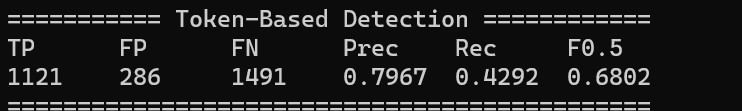